**Your challenge can be found toward the end of this notebook. The code below will be needed in order to begin the challenge. Read through and execute all necessary portions of this code to complete the tasks for this challenge.**

##### Import the necessary packages

In [2]:
!pip install graphviz

In [3]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
mpl.rcParams['figure.dpi'] = 400 #high res figures
import graphviz #to visualize decision trees

##### Cleaning the Dataset

In [4]:
df_orig = pd.read_excel('default_of_credit_card_clients.xls')

In [5]:
df_zero_mask = df_orig == 0

In [6]:
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)

In [7]:
sum(feature_zero_mask)
# 315

315

Remove all the rows with all zero features and response, confirm this that gets rid of the duplicate IDs.

In [8]:
df_clean = df_orig.loc[~feature_zero_mask,:].copy()

In [9]:
df_clean.shape
# (29685, 25)

(29685, 25)

In [10]:
df_clean['ID'].nunique()
# 29685

29685

Clean up the `EDUCATION` and `MARRIAGE` features as in Chapter 1

In [11]:
df_clean['EDUCATION'].value_counts()
# 2    13884
# 1    10474
# 3     4867
# 5      275
# 4      122
# 6       49
# 0       14
# Name: EDUCATION, dtype: int64

2    13884
1    10474
3     4867
5      275
4      122
6       49
0       14
Name: EDUCATION, dtype: int64

"Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)"

Assign unknown categories to other.

In [12]:
df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)

In [13]:
df_clean['EDUCATION'].value_counts()
# 2    13884
# 1    10474
# 3     4867
# 4      460
# Name: EDUCATION, dtype: int64

2    13884
1    10474
3     4867
4      460
Name: EDUCATION, dtype: int64

Examine and clean marriage feature as well:

In [14]:
df_clean['MARRIAGE'].value_counts()
# 2    15810
# 1    13503
# 3      318
# 0       54
# Name: MARRIAGE, dtype: int64

2    15810
1    13503
3      318
0       54
Name: MARRIAGE, dtype: int64

In [15]:
#Should only be (1 = married; 2 = single; 3 = others).
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)

In [16]:
df_clean['MARRIAGE'].value_counts()
# 2    15810
# 1    13503
# 3      372
# Name: MARRIAGE, dtype: int64

2    15810
1    13503
3      372
Name: MARRIAGE, dtype: int64

Now instead of removing rows with `PAY_1` = 'Not available', as done in Chapter 1, here select these out for addition to training and testing splits.

In [17]:
df_clean['PAY_1'].value_counts()
# 0                13087
# -1                5047
# 1                 3261
# Not available     3021
# -2                2476
# 2                 2378
# 3                  292
# 4                   63
# 5                   23
# 8                   17
# 6                   11
# 7                    9
# Name: PAY_1, dtype: int64

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

In [18]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'
missing_pay_1_mask

0        False
1        False
2        False
3        False
4        False
         ...  
29995    False
29996    False
29997    False
29998    False
29999    False
Name: PAY_1, Length: 29685, dtype: bool

In [19]:
sum(missing_pay_1_mask)
# 3021

3021

In [20]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()

In [21]:
df_missing_pay_1.shape
# (3021, 25)

(3021, 25)

In [22]:
df_missing_pay_1['PAY_1'].head(3)

17    Not available
28    Not available
29    Not available
Name: PAY_1, dtype: object

In [23]:
df_missing_pay_1['PAY_1'].value_counts()

Not available    3021
Name: PAY_1, dtype: int64

In [24]:
df_missing_pay_1.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

Load cleaned data

In [25]:
df = pd.read_csv('cleaned_data.csv')

In [26]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

In [27]:
features_response = df.columns.tolist()

In [28]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [29]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

##### Mode and Random Imputation of `PAY_1`

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# (21331, 17)
# (5333, 17)
# (21331,)
# (5333,)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


In [33]:
df_missing_pay_1.shape

(3021, 25)

In [34]:
features_response[4]

'PAY_1'

In [35]:
np.median(X_train[:,4])

0.0

In [36]:
np.random.seed(seed=1)
fill_values = [0, np.random.choice(X_train[:,4], size=(3021,), replace=True)]

In [37]:
fill_values

[0, array([ 0,  0,  0, ...,  2,  0, -2], dtype=int64)]

In [38]:
fill_strategy = ['mode', 'random']

In [39]:
fill_values[-1]

array([ 0,  0,  0, ...,  2,  0, -2], dtype=int64)

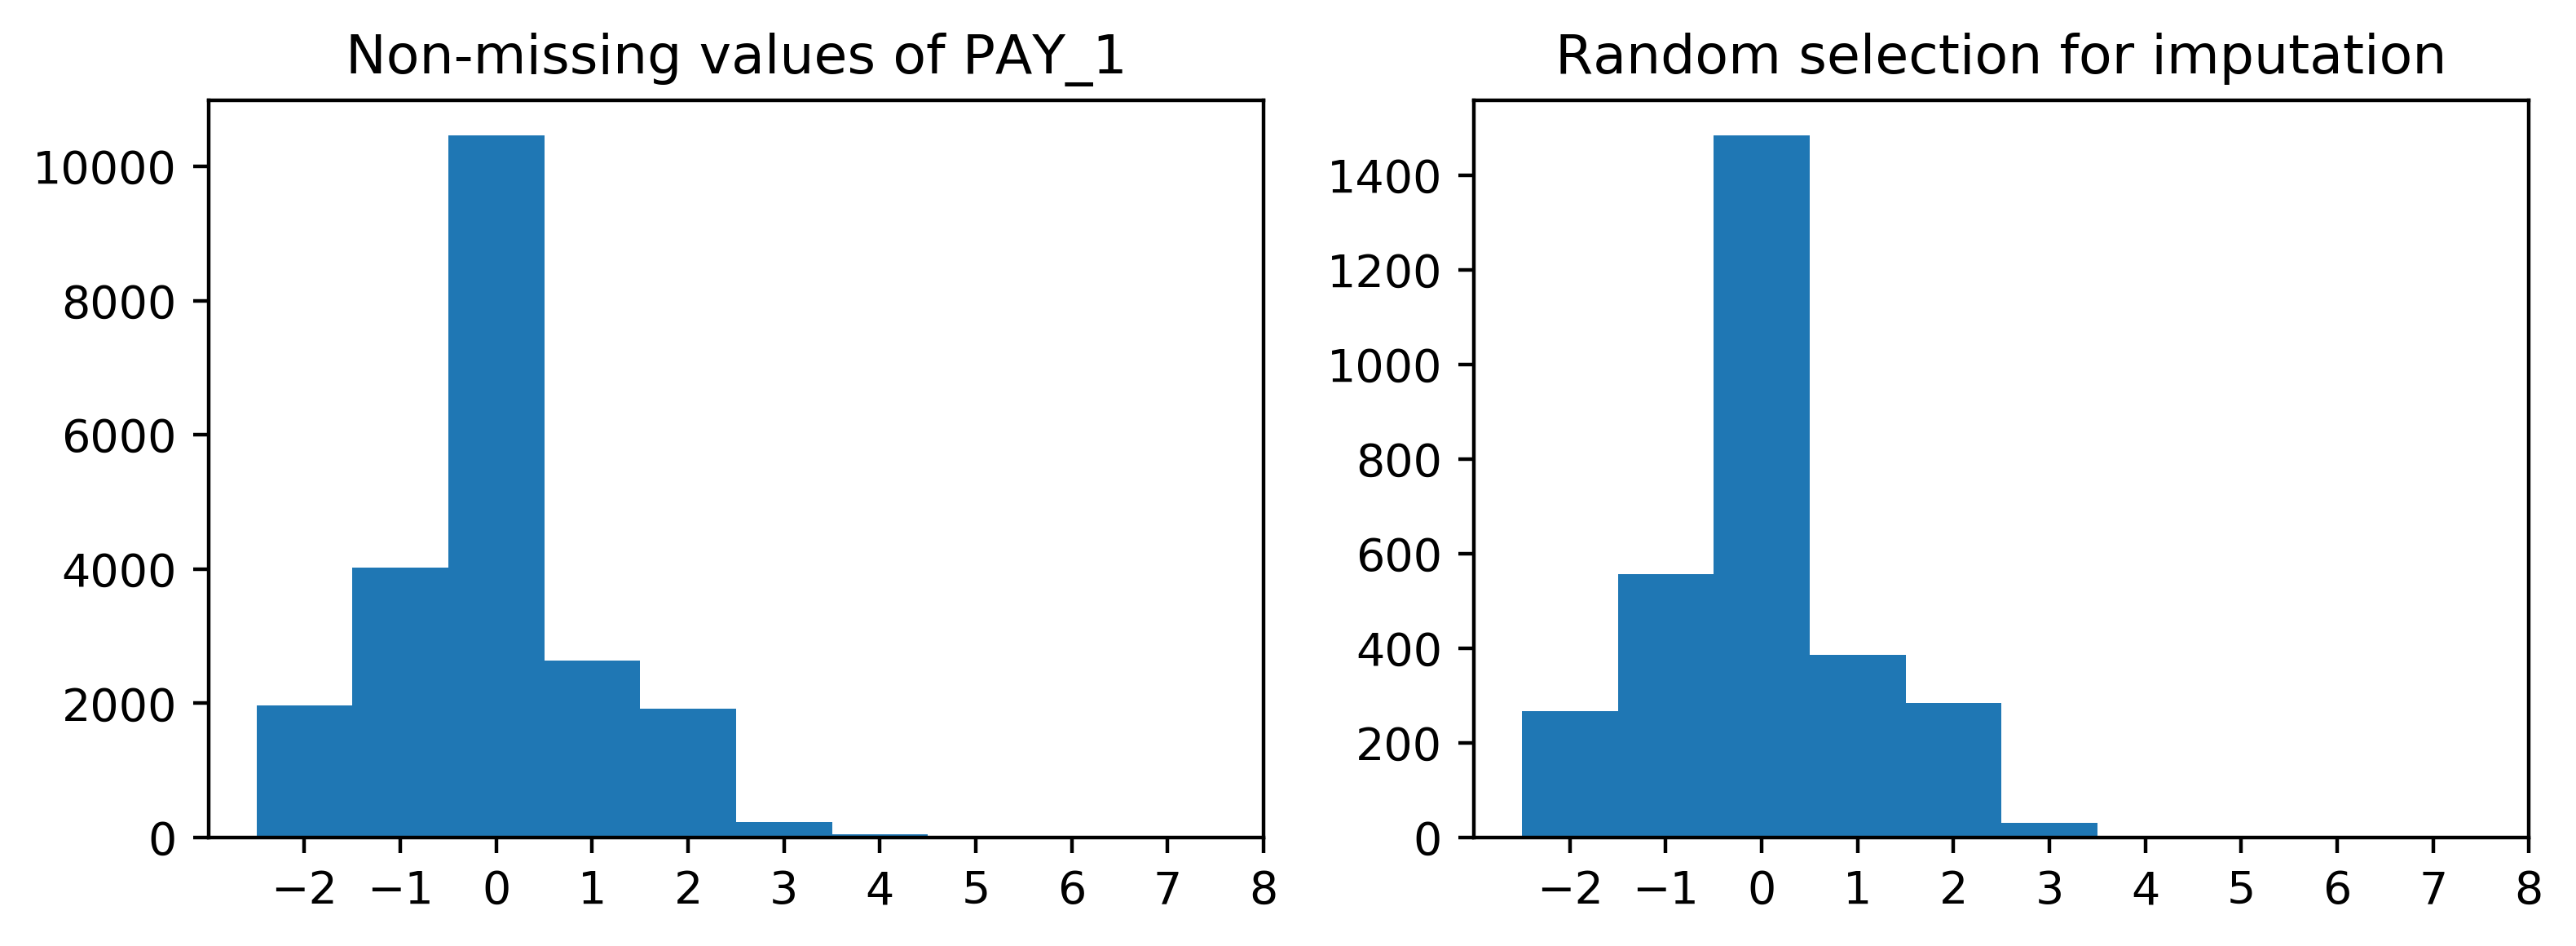

In [40]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(X_train[:,4], bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(fill_values[-1], bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Random selection for imputation')
plt.tight_layout()

To do cross-validation on the training set, now we need to shuffle since all the samples with missing `PAY_1` were concatenated on to the end.

In [41]:
from sklearn.model_selection import KFold

In [42]:
k_folds = KFold(n_splits=4, shuffle=True, random_state=1)

Don't need to do a grid search, so we can use `cross_validate`

In [43]:
from sklearn.model_selection import cross_validate

For the estimator, set the optimal hyperparameters determined in previous chapter.

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rf = RandomForestClassifier\
(n_estimators=200, criterion='gini', max_depth=9,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
random_state=4, verbose=1, warm_start=False, class_weight=None)

In [46]:
for counter in range(len(fill_values)):
    #Copy the data frame with missing PAY_1 and assign imputed values
    df_fill_pay_1_filled = df_missing_pay_1.copy()
    df_fill_pay_1_filled['PAY_1'] = fill_values[counter]
    
    #Split imputed data in to training and testing, using the same
    #80/20 split we have used for the data with non-missing PAY_1
    X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
    train_test_split(
        df_fill_pay_1_filled[features_response[:-1]].values,
        df_fill_pay_1_filled['default payment next month'].values,
    test_size=0.2, random_state=24)
    
    #Concatenate the imputed data with the array of non-missing data
    X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
    y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
    
    #Use the KFolds splitter and the random forest model to get
    #4-fold cross-validation scores for both imputation methods
    imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise-deprecating')
    
    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[counter] + ' imputation: ' +
          'mean testing score ' + str(np.mean(test_score)) +
          ', std ' + str(np.std(test_score)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


mode imputation: mean testing score 0.772866246168149, std 0.0031479941297533737
random imputation: mean testing score 0.7692540439833129, std 0.003660875187678248


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.8s finished


##### A Predictive Model for `PAY_1`

In [47]:
pay_1_df = df.copy()

In [48]:
features_for_imputation = pay_1_df.columns.tolist()

In [49]:
items_to_remove_2 = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university', 'default payment next month', 'PAY_1']

In [50]:
features_for_imputation = [item for item in features_for_imputation if item not in items_to_remove_2]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

##### Building a Multiclass Classification Model for Imputation

In [51]:
X_impute_train, X_impute_test, y_impute_train, y_impute_test = \
train_test_split(
    pay_1_df[features_for_imputation].values,
    pay_1_df['PAY_1'].values,
test_size=0.2, random_state=24)

In [52]:
rf_impute_params = {'max_depth':[3, 6, 9, 12],
             'n_estimators':[10, 50, 100, 200]}

In [53]:
from sklearn.model_selection import GridSearchCV

Need to use accuracy here as ROC AUC is not supported for multiclass. Need to use multiclass and not regression because need to limit to integer values of `PAY_1`.

In [54]:
cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring='accuracy',
                            n_jobs=-1, iid=False, refit=True,
                            cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [55]:
cv_rf_impute.fit(X_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   37.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=9,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=4,
                                              verbose=1, warm_start=False),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],

In [56]:
impute_df = pd.DataFrame(cv_rf_impute.cv_results_)
impute_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.232175,0.018216,0.018963,0.005224,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.665168,0.669541,0.672731,0.663225,0.667666,0.003712,15,0.669313,0.672481,0.665979,0.670020,0.669448,0.002322
1,0.941565,0.012069,0.062860,0.013271,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.656549,0.673290,0.676482,0.644077,0.662599,0.013102,16,0.665562,0.673168,0.670292,0.653212,0.665558,0.007628
2,1.978327,0.029757,0.099734,0.013838,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.671351,0.674414,0.680420,0.666792,0.673244,0.004952,13,0.677504,0.675919,0.673605,0.676393,0.675855,0.001421
3,3.972858,0.071381,0.234620,0.019266,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.663481,0.672352,0.680233,0.669044,0.671278,0.006065,14,0.672002,0.673106,0.671042,0.675581,0.672933,0.001694
4,0.346866,0.007328,0.021941,0.006268,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.702080,0.704967,0.701050,0.695701,0.700950,0.003353,12,0.714455,0.714929,0.709107,0.707011,0.711375,0.003403
5,1.578032,0.031887,0.079537,0.028788,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.706202,0.710965,0.718492,0.701521,0.709295,0.006273,11,0.719082,0.719617,0.722295,0.713447,0.718610,0.003220
6,3.357612,0.026895,0.120179,0.019499,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.710512,0.711153,0.716617,0.705087,0.710842,0.004083,10,0.721083,0.719180,0.720920,0.716071,0.719313,0.002015
7,6.757328,0.138539,0.232522,0.018214,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.712385,0.709278,0.716804,0.706965,0.711358,0.003686,9,0.721145,0.718055,0.719357,0.716883,0.718860,0.001583
8,0.476235,0.027219,0.016711,0.004920,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.719318,0.725586,0.722056,0.721795,0.722188,0.002234,7,0.768101,0.772631,0.770423,0.771932,0.770772,0.001736
9,2.332918,0.162139,0.075192,0.015315,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.727937,0.725586,0.727869,0.731181,0.728143,0.001993,5,0.771852,0.772881,0.776424,0.771995,0.773288,0.001853


In [57]:
cv_rf_impute.best_params_
# {'max_depth': 12, 'n_estimators': 100}

{'max_depth': 12, 'n_estimators': 100}

In [58]:
cv_rf_impute.best_score_
# 0.7337676389523727

0.7337676389523727

In [59]:
pay_1_value_counts = pay_1_df['PAY_1'].value_counts().sort_index()

In [60]:
pay_1_value_counts

-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: PAY_1, dtype: int64

In [61]:
pay_1_value_counts/pay_1_value_counts.sum()

-2    0.092859
-1    0.189281
 0    0.490812
 1    0.122300
 2    0.089184
 3    0.010951
 4    0.002363
 5    0.000863
 6    0.000413
 7    0.000338
 8    0.000638
Name: PAY_1, dtype: float64

In [62]:
y_impute_predict = cv_rf_impute.predict(X_impute_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [63]:
from sklearn import metrics

In [64]:
metrics.accuracy_score(y_impute_test, y_impute_predict)

0.7387961747609225

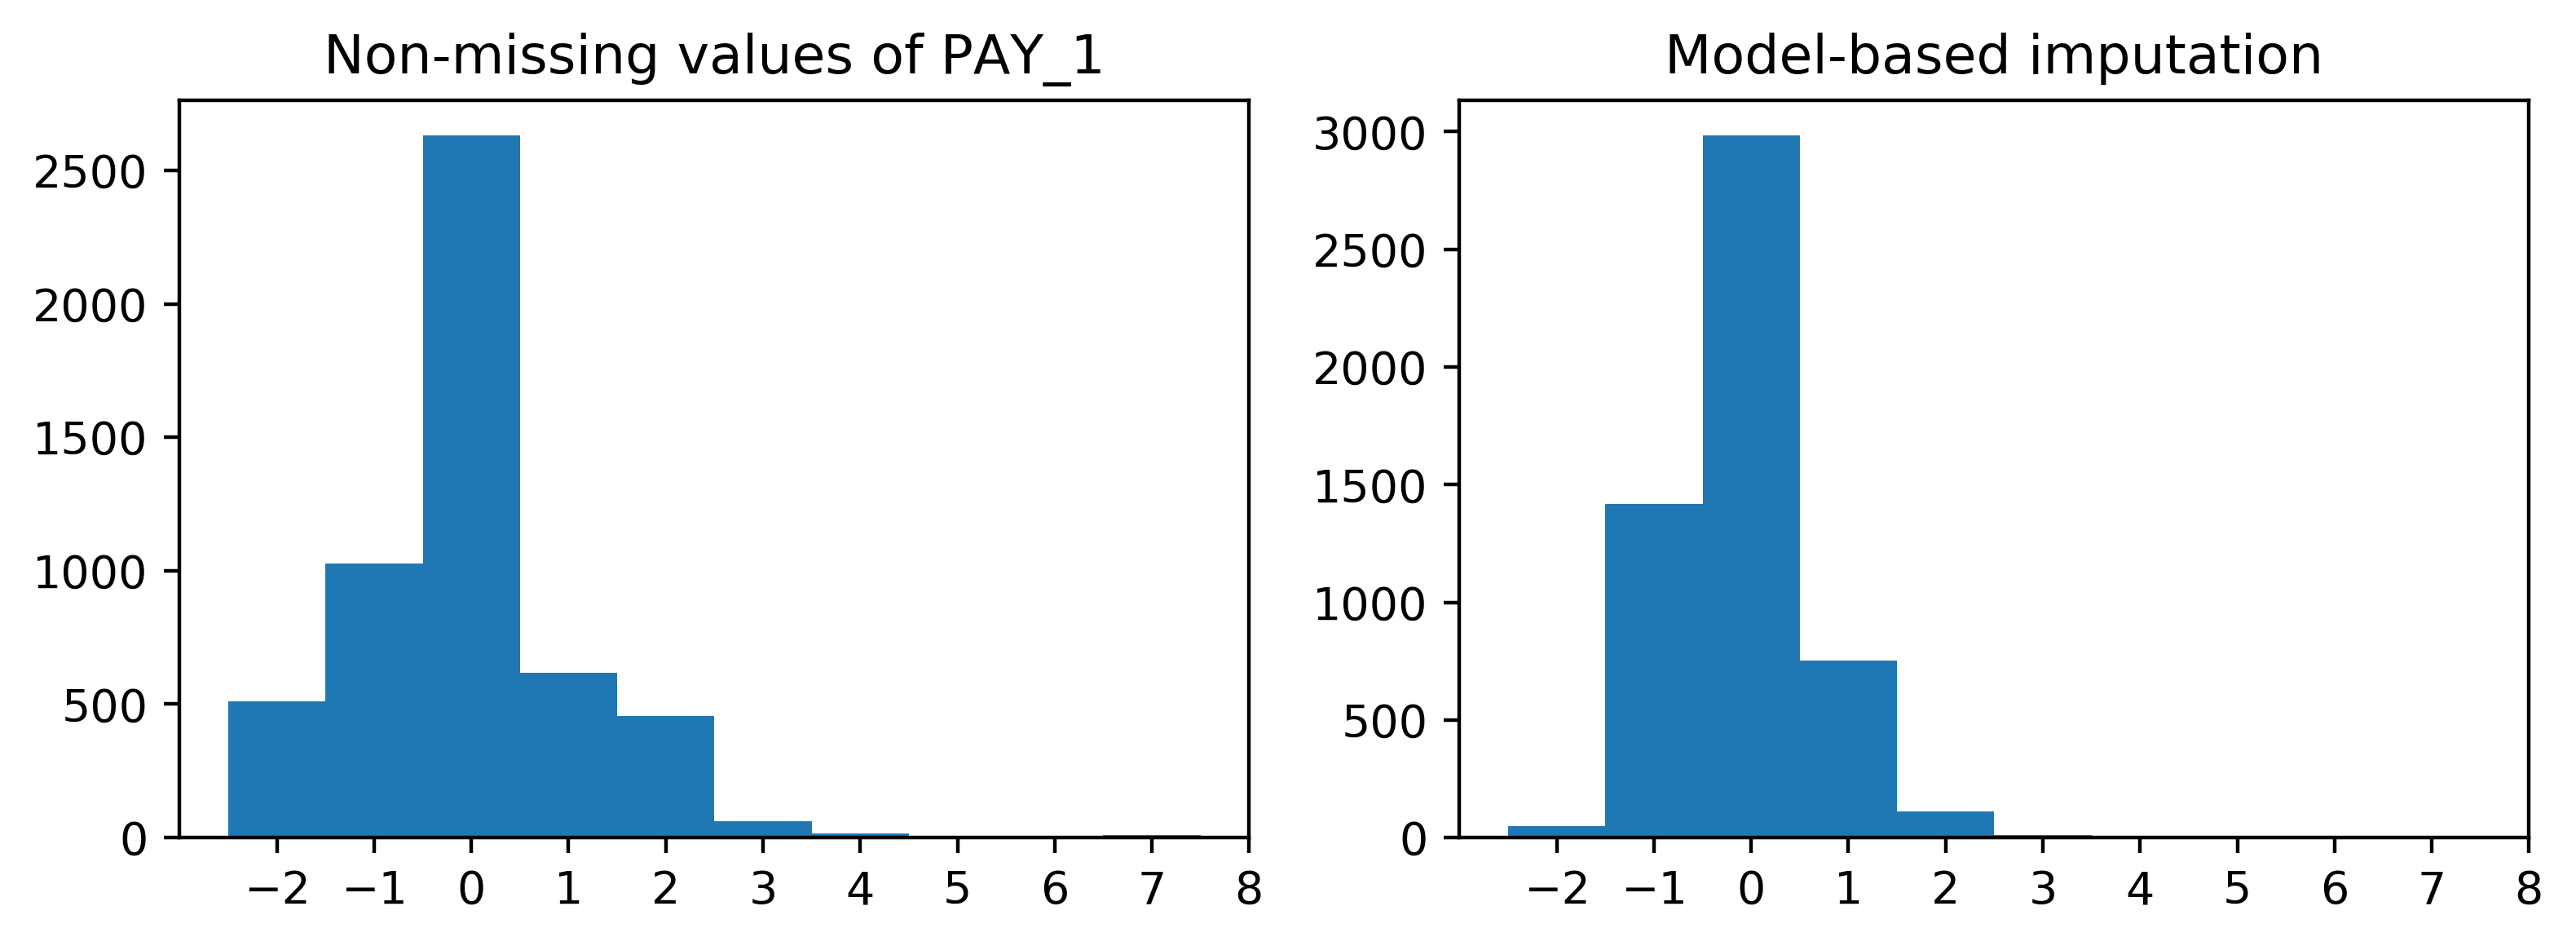

In [65]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Model-based imputation')
plt.tight_layout()

In [66]:
X_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

In [67]:
rf_impute = RandomForestClassifier(n_estimators=100, max_depth=12)

In [68]:
rf_impute

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [69]:
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##### Using the Imputation Model and Comparing it to Other Methods

In [70]:
df_fill_pay_1_model = df_missing_pay_1.copy()

In [71]:
df_fill_pay_1_model['PAY_1'].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

In [72]:
df_fill_pay_1_model['PAY_1'] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)

In [73]:
df_fill_pay_1_model['PAY_1'].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

In [74]:
df_fill_pay_1_model['PAY_1'].value_counts().sort_index()

-2      30
-1     763
 0    1715
 1     438
 2      64
 3       7
 4       2
 6       1
 8       1
Name: PAY_1, dtype: int64

In [75]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

In [76]:
print(X_fill_pay_1_train.shape)
print(X_fill_pay_1_test.shape)
print(y_fill_pay_1_train.shape)
print(y_fill_pay_1_test.shape)

(2416, 17)
(605, 17)
(2416,)
(605,)


In [77]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

In [78]:
print(X_train_all.shape)
print(y_train_all.shape)

(23747, 17)
(23747,)


In [79]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=4, verbose=1,
                       warm_start=False)

In [80]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.2s finished


In [81]:
imputation_compare_cv['test_score']
# array([0.76890992, 0.77309591, 0.77166336, 0.77703366])

array([0.76890992, 0.77309591, 0.77166336, 0.77703366])

In [82]:
np.mean(imputation_compare_cv['test_score'])
# 0.7726757126815554

0.7726757126815554

In [83]:
np.std(imputation_compare_cv['test_score'])
# 0.002931480680760725

0.002931480680760725

Reassign values using mode imputation

In [84]:
df_fill_pay_1_model['PAY_1'] = np.zeros_like(df_fill_pay_1_model['PAY_1'].values)

In [85]:
df_fill_pay_1_model['PAY_1'].unique()

array([0], dtype=int64)

In [86]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

In [87]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

In [88]:
print(X_train_all.shape)
print(X_test_all.shape)
print(y_train_all.shape)
print(y_test_all.shape)

(23747, 17)
(5938, 17)
(23747,)
(5938,)


In [89]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                       cv=k_folds, n_jobs=-1, verbose=1,
                                       return_train_score=True, return_estimator=True,
                                       error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.6s finished


In [90]:
np.mean(imputation_compare_cv['test_score'])

0.772866246168149

##### Confirming Model Performance on the Unseen Test Set

In [91]:
rf.fit(X_train_all, y_train_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=4, verbose=1,
                       warm_start=False)

In [92]:
y_test_all_predict_proba = rf.predict_proba(X_test_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [93]:
from sklearn.metrics import roc_auc_score

In [94]:
roc_auc_score(y_test_all, y_test_all_predict_proba[:,1])
# 0.7696243835824927

0.7696243835824927

##### Characterizing Costs and Savings

In [95]:
thresholds = np.linspace(0, 1, 101)

Use mean bill amount to estimate savings per prevented default

In [96]:
df[features_response[:-1]].columns[5]

'BILL_AMT1'

In [97]:
savings_per_default = np.mean(X_test_all[:, 5])
savings_per_default
# 51601.7433479286

51601.7433479286

In [98]:
cost_per_counseling = 7500

In [99]:
effectiveness = 0.70

In [100]:
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
savings_of_all_counselings = np.empty_like(thresholds)

In [101]:
counter = 0
for threshold in thresholds:
    pos_pred = y_test_all_predict_proba[:,1]>threshold
    n_pos_pred[counter] = sum(pos_pred)
    cost_of_all_counselings[counter] = n_pos_pred[counter] * cost_per_counseling
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    savings_of_all_counselings[counter] = n_true_pos[counter] * savings_per_default * effectiveness
    
    counter += 1

In [102]:
net_savings = savings_of_all_counselings - cost_of_all_counselings

In [103]:
# plt.plot(thresholds, cost_of_all_counselings)

In [104]:
# plt.plot(thresholds, savings_of_all_counselings)

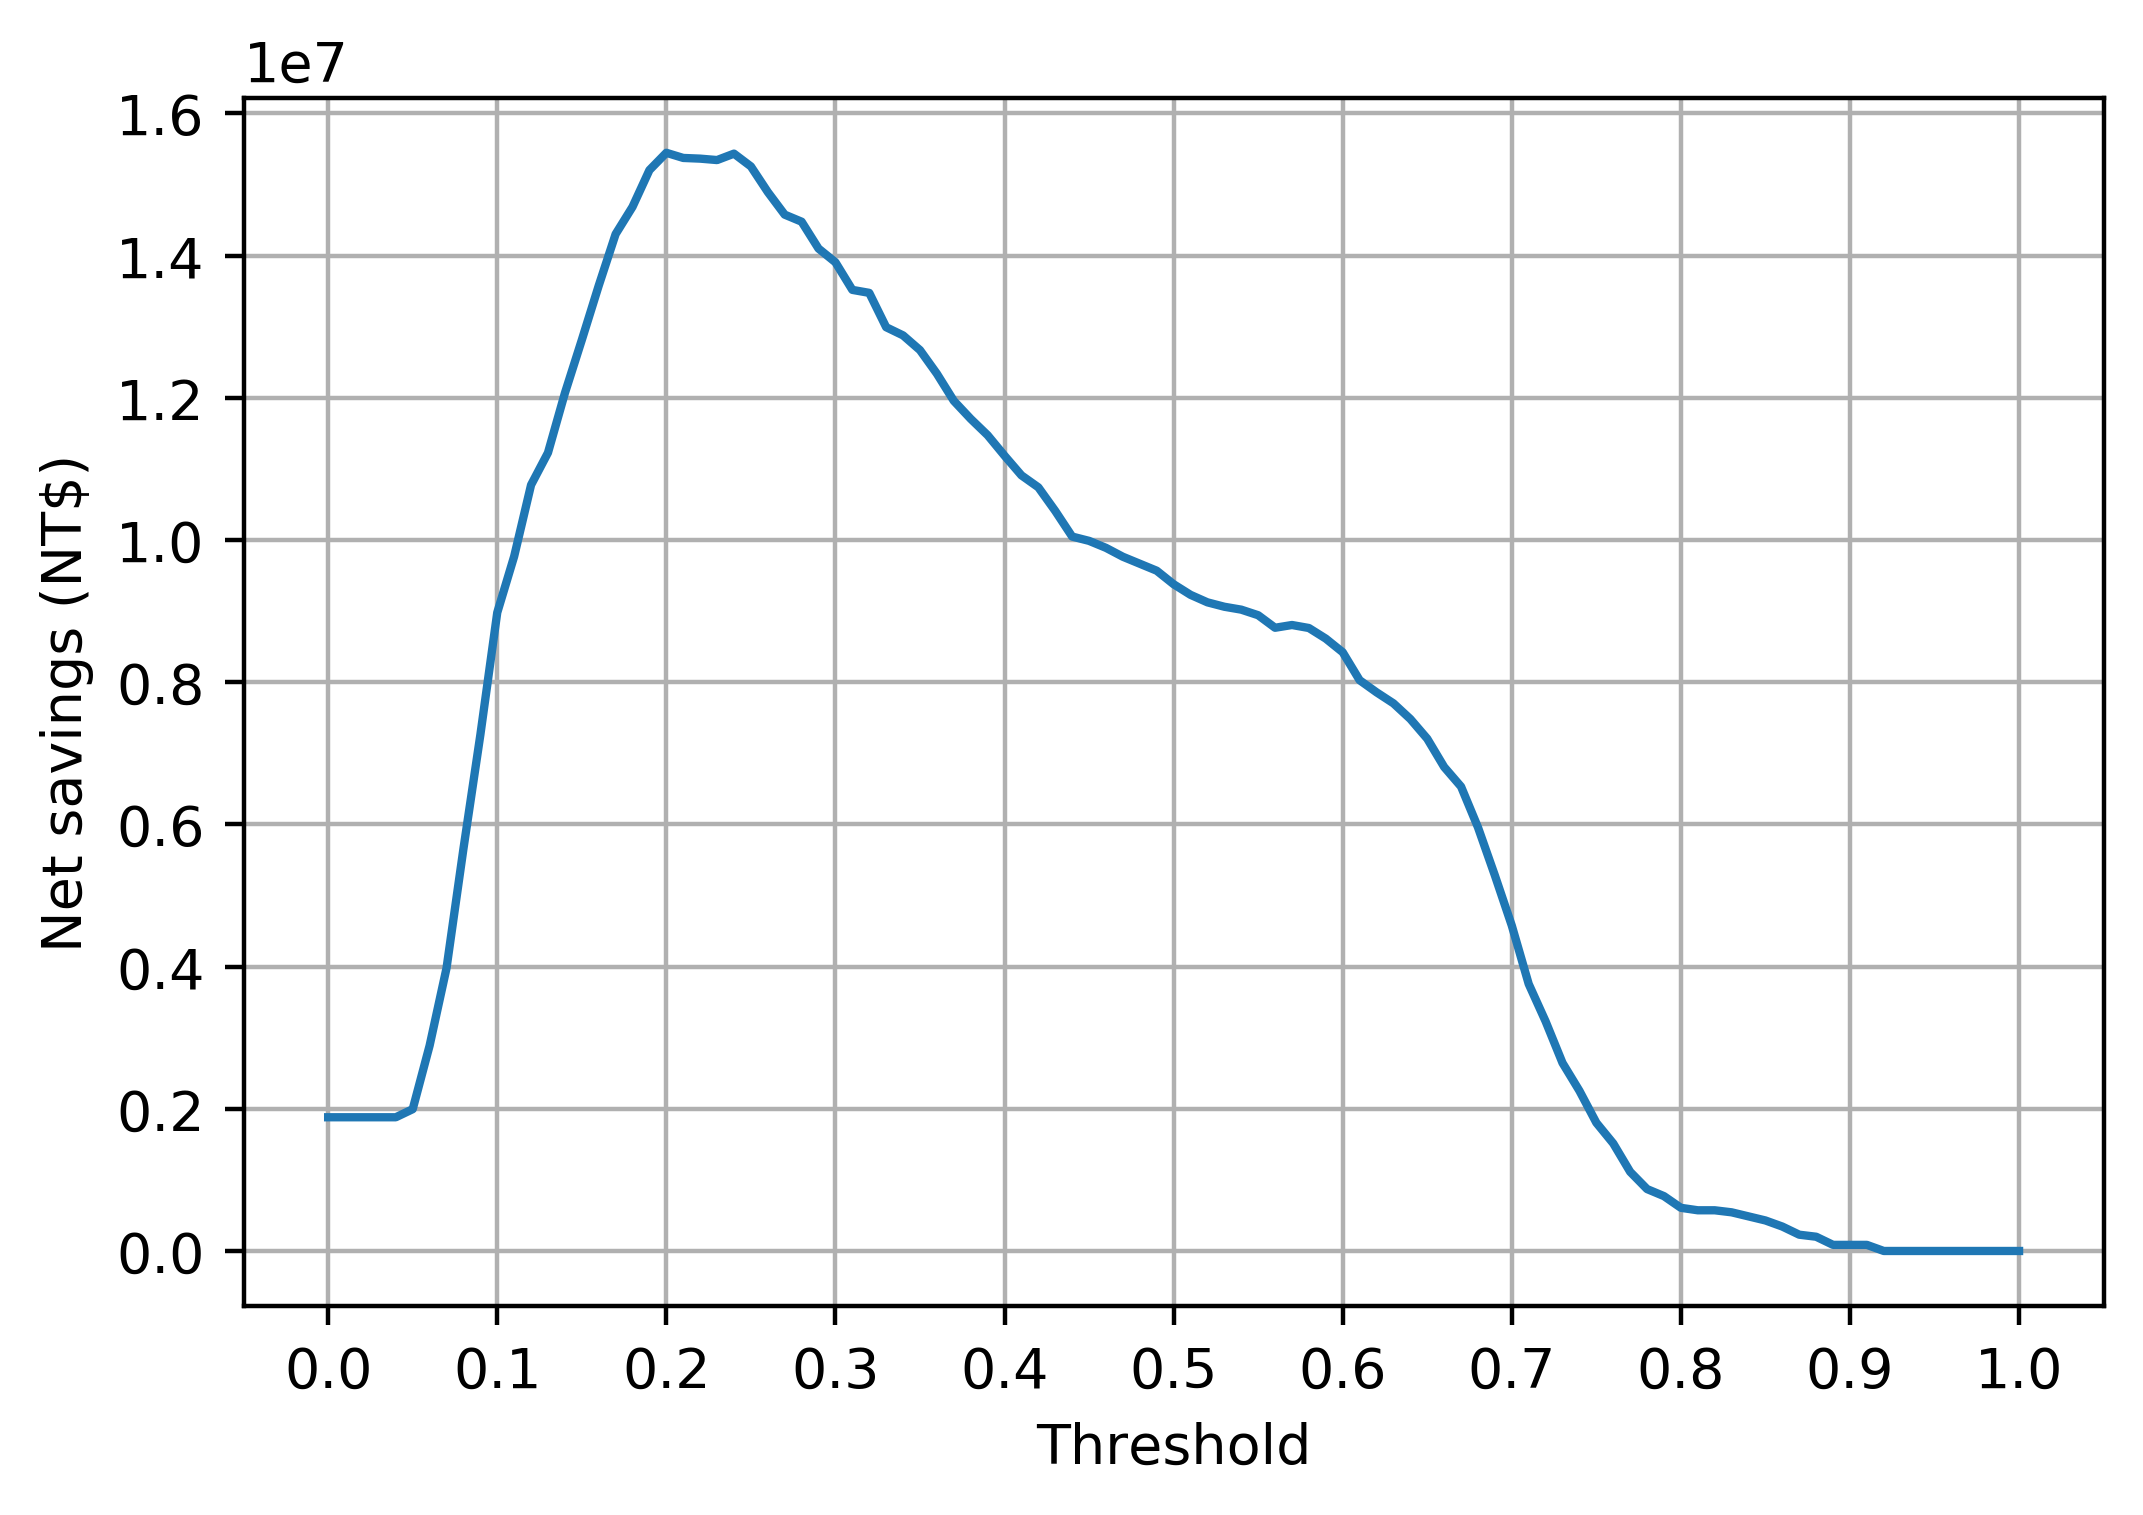

In [105]:
mpl.rcParams['figure.dpi'] = 400
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [106]:
max_savings_ix = np.argmax(net_savings)

What is the threshold at which maximum savings is achieved?

In [107]:
thresholds[max_savings_ix]
# 0.2

0.2

What is the maximum possible savings?

In [108]:
net_savings[max_savings_ix]
# 15446325.35991916

15446325.35991916

## Challenge: Deriving Financial Insights

    Everything that is needed prior to this challenge has been included in the notebook above. You should run all the necessary portions of the provided code before beginning these tasks.

In [ ]:
# This will autosave your notebook every ten seconds
%autosave 10

**Using the testing set, calculate the cost of all defaults if there were no counseling program and output your result.**

_______________________________________________________________________________________________
**Next, calculate by what percent can the cost of defaults be decreased by the counseling program and output you result.**

_______________________________________________________________________________________________
**Then, calculate the net savings per account at the optimal threshold and output your result.**

_______________________________________________________________________________________________
**Now, plot the net savings per account against the cost of counseling per account for each threshold.**

_______________________________________________________________________________________________
**Next, plot the fraction of accounts predicted as positive (this is called the "flag rate") at each threshold.**

_______________________________________________________________________________________________
**Next, plot a precision-recall curve for the testing data.**

_______________________________________________________________________________________________
**Finally, plot precision and recall separately on the y-axis against threshold on the x-axis.**